In [9]:
path = {
    "axo": r"..\example\AXO",
    "rdl": r"..\example\RDL",
    "opt": r"..\example\OPT",
    "rt": r"..\example\RT",
    "cond": r"..\example\CONDITIONS",
    "prop": r"..\example\PROPERTY",
    "output": r"..\output"
}

In [25]:
# define loading function
import pandas as pd
import numpy as np
import os

# axo
def axo_load(path, cond=pd.DataFrame()):
    """
    The path and the file name need to be below:
    Could be multiple file
    ─┬─ folder[path]
     ├─ 1-1 + 1-2 + 1-3.csv
     ├─ 1-4.csv
     ...
    """
    df = pd.DataFrame()
    loc = [5, 3, 1, 6, 4, 2]
    for cwd, dir_name, file_names in os.walk(path):
        for f in file_names:
            file = os.path.join(cwd, f)
            # get short-id from file name
            # Cause there may be multiple panel in one file, we need to
            # deal with it.
            short_id = f.split(".")[0]
            short_id = [s.strip() for s in short_id.split("+")]
            # multiple each point 6 times cause there are 6 point in one panel
            # maybe I should split this function to another place?
            short_id_6 = [id for id in short_id for _ in range(6)]
            location_6 = loc * len(short_id)
            # Todo: more error format handling
            
            tmp_df = pd.read_csv(file, engine="python", skiprows=27, skipfooter=92)
            tmp_df.insert(loc = 1, column = "short-id", value=short_id_6)
            tmp_df.insert(loc = 2, column = "point", value = location_6)
            df = pd.concat([df, tmp_df], ignore_index=True)
    # replace short-id if you have condition table
    if cond.empty != True:
        df = df.rename(columns={"short-id": "ID", "Chip No.": "LC"})
        df["ID"] = df["ID"].map(dict(cond[["Short-id", "id"]].values))
        df["LC"] = df["ID"].map(dict(cond[["id", "LC"]].values))
        # neglect the data that doesn't record
        df = df[~df["ID"].isna()]
        df.columns = ["LC", "ID", "point", "x", "y", "cell gap", "top rubbing direct", "twist", "top pre-tilt", "bottom pre-tilt", "rms", "iteration"]

    return df

def rdl_load(path, cond=pd.DataFrame()):
    """
    The path and the file name need to be below:
    Should be single file.
    ─┬─ folder[path]
     └─ [cell gap].xlsx
    """
    file = next(os.walk(path))[2][0]
    df = pd.read_excel(os.path.join(path, file))
    if cond.empty != True:
        df = df.rename(columns={"Short-id": "ID"})
        df["ID"] = df["ID"].map(dict(cond[["Short-id", "id"]].values))
        df["LC"] = df["ID"].map(dict(cond[["id", "LC"]].values))
        # neglect the data that doesn't record
        df = df[~df["ID"].isna()]
        df.columns = ['ID', 'cell gap', 'LC']
    return df

def opt_load(path, cond=pd.DataFrame()):
    """
    The path and the file name need to be below:
    Could be multiple file
    ─┬─ folder[path]
     ├─ xxxx.csv
     ├─ xxxx.csv
     ...
    """
    df = pd.DataFrame()
    for cwd, dir_name, file_names in os.walk(path):
        for f in file_names:
            file = os.path.join(cwd, f)
            tmp_df = pd.read_csv(file, encoding="ansi")
            df = pd.concat([df, tmp_df], ignore_index=True)
            
    # some data preprocessing
    df.columns = ['Data', 'M_Time', 'ID', 'Point', 'Station', 'Operator', 'Voltage',
       'I.Time', 'AR_T%(⊥)', 'AR_T%(//)', 'LCM_X%', 'LCM_Y%', 'LCM_Z%', 'RX',
       'RY', 'RZ', 'GX', 'GY', 'GZ', 'BX', 'BY', 'BZ', 'WX', 'WY', 'WZ', 'CG%',
       'R_x', 'R_y', 'G_x', 'G_y', 'B_x', 'B_y', 'W_x', 'W_y', 'RX_max',
       'GY_max', 'BZ_max', 'V_RX_max', 'V_GY_max', 'V_BZ_max', "WX'", "WY'",
       "WZ'", "W_x'"," W_x'.1", 'LCM_X%max', 'LCM_Y%max', 'LCM_Z%max',
       'φ_(Ymax)', 'φ_(Ymax).1', 'φ_(Zmax)', 'φ_tol_X', 'φ_tol_Y', 'φ_tol_Z',
       'T0/Tmax_X', 'T0/Tmax_Y', 'T0/Tmax_Z', 'Vcri_X', 'Vcri_Y', 'Vcri_Z',
       'dφ_X', 'dφ_Y', 'dφ_Z', 'LC']
    # voltage == 1 is the wrong rows, need drop
    df = df[df["Voltage"] != 1]
    if cond.empty != True:
        df["LC"] = df["ID"].map(dict(cond[["id", "LC"]].values))
    return df

def rt_load(path, cond=pd.DataFrame()):
    """
    The path and the file name need to be below:
    Could be multiple file
    ─┬─ folder[path]
     ├─ xxxx.txt
     ├─ xxxx.txt
     ...
    """
    df = pd.DataFrame()
    for cwd, dir_name, file_names in os.walk(path):
        for f in file_names:
            if f[0] == ".":
                continue
            if f[0] == "~":
                continue
            file = os.path.join(cwd, f)
            tmp_df = pd.read_table(file, encoding="ansi")
            df = pd.concat([df, tmp_df], ignore_index=True)
    # some system encoding would go wrong, so I rename here
    df.columns = ['量測日期', '時間', 'ID', 'point', '站點', '量測人員', 'cell pos.', 'Target Vpk',
       'Initial Vpk', 'OD_Rise', 'OD_fall', 'Normalized_V', 'Specific_target',
       'Photo Sensor', '溫度Sensor', '溫度', '產品別', 'Rise-mean (10-90)',
       'Rise-stdev (10-90)', 'Fall-mean (10-90)', 'Fall-stdev (10-90)',
       'Rise-mean (5-95)', 'Rise-stdev (5-95)', 'Fall-mean (5-95)',
       'Fall-stdev (5-95)', 'Vcom', 'Flicker', 'Base lv-mean', 'Top lv-mean',
       'WXT (%)', 'BXT (%)', 'WXT_*', 'BXT_*', 'Overshooting or not',
       'Overshooting %', '亮托尾時間', 'overshooting_peak', 'overshooting_top',
       '(RisePeak-top)/top', '(FallPeak-base)/base', 'delta_peak', 'delta_v',
       'delta_m', 'c_a', 'peak', 'top', 'HLH_(Peak-Top)', 'HLH_area']
    if cond.empty != True:
        df["LC"] = df["ID"].map(dict(cond[["id", "LC"]].values))
    df = df.astype({"point": 'int64'})
    df = df[df["ID"]!="NAN"]
    
    return df

def cond_load(path):
    """
    The path and the file name need to be below:
    Should be single file.
    ─┬─ folder[path]
     └─ [cond].xlsx
    """
    file = next(os.walk(path))[2][0]
    df = pd.read_excel(os.path.join(path, file))
    df = df.iloc[:,0:3]
    return df

def prop_load(path):
    """
    The path and the file name need to be below:
    Should be single file.
    ─┬─ folder[path]
     └─ [prop].xlsx
    """
    file = next(os.walk(path))[2][0]
    df = pd.read_excel(os.path.join(path, file))
    df['Scatter index'] = (df['n_e'] ** 2 - df['n_o'] ** 2) * 3 / df['K11(pN)'] + df['K22(pN)'] + df['K33(pN)']
    df['RT index'] = df['rotation viscosity (γ1)(mPa⋅s)'] / df['K22(pN)']
    return df

In [26]:
# loading data from raw
cond = cond_load(path["cond"])
axo = axo_load(path["axo"], cond)
rdl = rdl_load(path["rdl"], cond)
opt = opt_load(path["opt"], cond)
rt = rt_load(path["rt"], cond)
prop = prop_load(path["prop"])

In [27]:
prop

,LC,Vendor,measure T(°C),Tni(°C),Tcn(°C),design cell gap,n_e,n_o,ε_∥,ε_⊥,rotation viscosity (γ1)(mPa⋅s),K11(pN),K22(pN),K33(pN),Scatter index,RT index
0,LCT-19-580,Merck,25,79.4,-30,3.0,1.5925,1.4858,3.7,7.7,81,14.6,7.3,15.2,22.567491,11.09589
1,MOX-1,Merck,25,80.4,-30,2.5,1.6213,1.4921,3.8,7.7,81,14.3,7.2,14.8,22.084388,11.25000


In [29]:
# writing to database
import sqlalchemy as sql

engine = sql.create_engine('sqlite:///../database/demo.db', echo=False)
# engine = sql.create_engine('sqlite://', echo=True)

meta = sql.MetaData()
sql.Table(
    "cond", meta,
    sql.Column("LC", sql.String),
    sql.Column("Short-id", sql.String),
    sql.Column("ID", sql.String, unique=True),
)

meta.create_all(engine)

cond.to_sql("cond", con=engine, if_exists="append", index=False)
axo.to_sql("axo", con=engine, if_exists="append", index=False)
rdl.to_sql("rdl", con=engine, if_exists="append", index=False)
opt.to_sql("opt", con=engine, if_exists="append", index=False)
rt.to_sql("rt", con=engine, if_exists="append", index=False)
prop.to_sql("prop", con=engine, if_exists="append", index=False)


In [93]:
# loading from database
source = "rdl"
engine = sql.create_engine('sqlite:///../database/demo.db', echo=False)
cell_gap = pd.read_sql(f"SELECT * FROM {source}", engine)

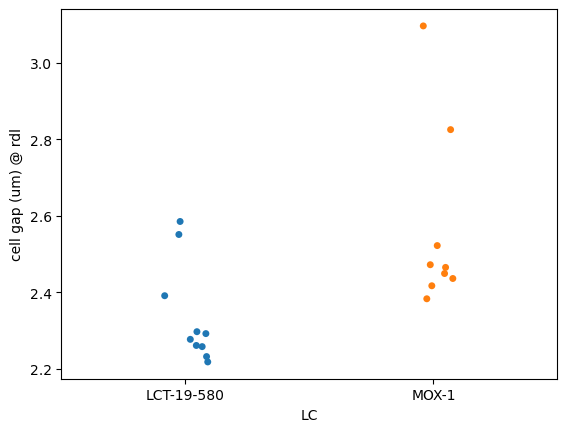

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.stripplot(data=cell_gap, x="LC", y="cell gap(um)")
plt.ylabel(f"cell gap (um) @ {source}")

plt.savefig("../output/demo.png")
plt.show()

In [82]:
opt = pd.read_sql("SELECT * FROM opt", engine)
opt["Voltage"].unique()

array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
        4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
        8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
       13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
       17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. ])

In [59]:
# export as excel
def query(url, LC=""):
    engine = sql.create_engine(url, echo=False)
    query = {}
    if LC == "":
        query["cond"] = pd.read_sql(f"SELECT * FROM cond", engine)
        query["axo"] = pd.read_sql(f"SELECT * FROM axo", engine)
        query["rdl"] = pd.read_sql(f"SELECT * FROM rdl", engine)
        query["opt"] = pd.read_sql(f"SELECT * FROM opt", engine)
        query["rt"] = pd.read_sql(f"SELECT * FROM rt", engine)
        query["prop"] = pd.read_sql(f"SELECT * FROM prop", engine)
    else:
        query["cond"] = pd.read_sql(f"SELECT * FROM cond WHERE LC == {LC}", engine)
        query["axo"] = pd.read_sql(f"SELECT * FROM axo WHERE LC == {LC}", engine)
        query["rdl"] = pd.read_sql(f"SELECT * FROM rdl WHERE LC == {LC}", engine)
        query["opt"] = pd.read_sql(f"SELECT * FROM opt WHERE LC == {LC}", engine)
        query["rt"] = pd.read_sql(f"SELECT * FROM rt WHERE LC == {LC}", engine)
        query["prop"] = pd.read_sql(f"SELECT * FROM prop WHERE LC == {LC}", engine)
        
    writer = pd.ExcelWriter(os.path.join(path["output"], "query_result.xlsx"), engine='xlsxwriter')
    for q_name, df in query.items():
        df.to_excel(writer, sheet_name=q_name)
    writer.save()

In [62]:
# querying and export to excel
url = 'sqlite:///../database/demo.db'
query(url) # Todo: 選單

# Todo #
1. 選單(GUI) > LC, 特性勾選(V-T, properties, cell gap vs rt)，並自動整理
    > 下週 DEMO
2. 資料庫存於伺服器？
3. properties 欄位(scatter index, rt index)
4. 資料來源標示
5. 南廠那邊 OPT voltage == 1 的資料意義
5. 自動生圖的資料來源
6. 供應商提供的資料(jar test.../merck, Seal 廠商提供等等)
    > 固定格式輸入表單 > 輸入完會直接更新資料庫
    > 選單 PK
    > 兩週後 DEMO
7. TR1 check list 資料
    > 一個月後 DEMO
8. 會議記錄
9. 連續跳票兩次花錢消災

In [17]:
import sys
print(sys.executable)
print(sys.path)

F:\opt\anaconda\python.exe
['F:\\dimsp\\Documents\\Projects\\tdtoolkit\\notebook\\tdtoolkits_demo\\src', 'F:\\opt\\anaconda\\python38.zip', 'F:\\opt\\anaconda\\DLLs', 'F:\\opt\\anaconda\\lib', 'F:\\opt\\anaconda', '', 'F:\\opt\\anaconda\\lib\\site-packages', 'F:\\opt\\anaconda\\lib\\site-packages\\win32', 'F:\\opt\\anaconda\\lib\\site-packages\\win32\\lib', 'F:\\opt\\anaconda\\lib\\site-packages\\Pythonwin', 'F:\\opt\\anaconda\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\dimsp\\.ipython']


In [4]:
import numpy
numpy.__version__

'1.19.2'

In [28]:
import os
print(os.getcwd())

F:\dimsp\Documents\Projects\tdtoolkit\notebook\tdtoolkits_demo\src
